# encoder -decoder LSTM model 구현 예제

- 지난번 many2many lstm 언어모델 구현에서 tiem series forecasting 문제로 변경

---

# import 

In [20]:
import numpy as np
import pandas as pd
from datasetsforecast.m4 import M4, M4Evaluation
import matplotlib.pyplot as plt
import time
from keras.layers import LSTM ,Dense, Bidirectional, Input, TimeDistributed
from keras.models import Sequential ,Model
from keras.callbacks import EarlyStopping
import keras.backend as K

---

# source data

In [108]:
df,*_= M4.load(directory='data',group = 'Hourly')

lst = list(set(df.loc[:,'unique_id']))

tt = [df[df.loc[:,'unique_id']==lst[i]].iloc[:,1:4].set_index(['ds']) 
      for i in range(len(lst))]

for l in range(len(tt)):
    for s in range(1, 25):
        tt[l]['shift_{}'.format(s)] = tt[l]['y'].shift(s)
        tt[l]['shift_{}'.format(s)] = tt[l]['y'].shift(s)
        
tt=[tt[i].dropna(axis=0) for i in range(len(tt))]

train = np.concatenate([np.array(tt[i].iloc[:,1:]) for i in range(len(tt))])
y = np.concatenate([np.array(tt[i].iloc[:,0]) for i in range(len(tt))]).reshape(-1,1)

from sklearn.preprocessing import MinMaxScaler
min_max_scaler1 = MinMaxScaler()

X_scale = min_max_scaler1.fit_transform(train)
y_scale = min_max_scaler1.fit_transform(y)

# target data

In [27]:
df = pd.read_csv('C:/Users/default.DESKTOP-2ISHQBS/Documents/R/time_ele/train.csv')

arr = df.iloc[:,9] # 전력소비량
date=  pd.to_datetime(df.iloc[:,2]) # 일시

df_= pd.DataFrame({'date':date,
              'ele': arr})

df_ = df_.set_index('date')

from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

df_['mmele'] = min_max_scaler.fit_transform(df_.iloc[:].to_numpy().reshape(-1,1))

df_ = df_.drop(['ele'],axis=1)

for s in range(1, 25):
    df_['shift_{}'.format(s)] = df_['mmele'].shift(s)
    df_['shift_{}'.format(s)] = df_['mmele'].shift(s)

df_ = df_.dropna()

y = df_.iloc[:,[0]].values #scaled 

X = df_.iloc[:,1:]

from sklearn.model_selection import train_test_split

x_train,x_test, y_train , y_test = train_test_split(X.iloc[-2400:,:],y[-2400:],shuffle=False, test_size=0.1)

In [231]:
class WINdow:
    def __init__(self,df,timestep):
        self.df = df
        self.timestep=timestep+1 # 예상한 timestep보다 1적기 때문에 +1
        
    def window(self):
        for i in range(1, self.timestep):
            df['shift_{}'.format(i)] = df.iloc[:,0].shift(i)
            df['shift_{}'.format(i)] = df.iloc[:,0].shift(i)
        window_df = df.dropna(axis=0) # 결측치 공간 제거
        self.window_df = window_df.iloc[:,::-1] # 좌우 반전
        
                
        self.feature= self.window_df.iloc[:,:-1].values
        self.y_label= self.window_df.iloc[:,-1].values
        
        return self. window_df 

`-` sourece data를 target data 와 data size 통일

In [194]:
a = ((X_scale.shape[0] // x_train.shape[0])*x_train.shape[0])
X_ad_scale= X_scale.flatten()[:int(a)].reshape(x_train.shape[0],-1)
y_ad_scale = y_scale[:int(a)].reshape(x_train.shape[0],-1)

In [ ]:
X_ad_scale.shape,x_train.shape,y_train.shape, x_test.shape

`-` 비교군 lstm fitting data shape

In [237]:

df =pd.DataFrame(X_scale.flatten()[:int(a)])#.reshape(-1,24).shape
dfwindow= WINdow(df,24)
dfwindow.window()

,shift_24,shift_23,shift_22,shift_21,shift_20,shift_19,shift_18,shift_17,shift_16,shift_15,...,shift_9,shift_8,shift_7,shift_6,shift_5,shift_4,shift_3,shift_2,shift_1,0
24,0.002205,0.001980,0.001962,0.001935,0.001841,0.001674,0.001279,0.001273,0.001159,0.000721,...,0.000357,0.000745,0.000832,0.001627,0.002091,0.002114,0.002121,0.002122,0.002184,0.002162
25,0.001980,0.001962,0.001935,0.001841,0.001674,0.001279,0.001273,0.001159,0.000721,0.000464,...,0.000745,0.000832,0.001627,0.002091,0.002114,0.002121,0.002122,0.002184,0.002162,0.002205
26,0.001962,0.001935,0.001841,0.001674,0.001279,0.001273,0.001159,0.000721,0.000464,0.000484,...,0.000832,0.001627,0.002091,0.002114,0.002121,0.002122,0.002184,0.002162,0.002205,0.001980
27,0.001935,0.001841,0.001674,0.001279,0.001273,0.001159,0.000721,0.000464,0.000484,0.000616,...,0.001627,0.002091,0.002114,0.002121,0.002122,0.002184,0.002162,0.002205,0.001980,0.001962
28,0.001841,0.001674,0.001279,0.001273,0.001159,0.000721,0.000464,0.000484,0.000616,0.000580,...,0.002091,0.002114,0.002121,0.002122,0.002184,0.002162,0.002205,0.001980,0.001962,0.001935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362875,0.000008,0.000010,0.000012,0.000015,0.000017,0.000017,0.000017,0.000018,0.000018,0.000017,...,0.000005,0.000002,0.000002,0.000002,0.000003,0.000003,0.000004,0.000005,0.000005,0.000007
362876,0.000010,0.000012,0.000015,0.000017,0.000017,0.000017,0.000018,0.000018,0.000017,0.000016,...,0.000002,0.000002,0.000002,0.000003,0.000003,0.000004,0.000005,0.000005,0.000007,0.000008
362877,0.000012,0.000015,0.000017,0.000017,0.000017,0.000018,0.000018,0.000017,0.000016,0.000015,...,0.000002,0.000002,0.000003,0.000003,0.000004,0.000005,0.000005,0.000007,0.000008,0.000010
362878,0.000015,0.000017,0.000017,0.000017,0.000018,0.000018,0.000017,0.000016,0.000015,0.000013,...,0.000002,0.000003,0.000003,0.000004,0.000005,0.000005,0.000007,0.000008,0.000010,0.000012


In [240]:
lstm_x= dfwindow.feature
lstm_y= dfwindow.y_label

lstm_x.shape, lstm_y.shape

((362856, 24), (362856,))

---

# model bulid

- encoder, decoder 형식
- 각 모델마다 두개의 lstm 레이어층 사용
- 각 층의 cell = 64

In [109]:
n= 64
encoder_feature = 1
decoder_feature = 1

In [253]:
K.clear_session()

####################################################################################
# encoder

encoder_input = Input(shape=(None,encoder_feature))
# encoder layer1 
encoder1 = LSTM(units=n, return_sequences=True, return_state=True) # return_state=True 출력,은닉,셀 반환옵션
output, encoder_h, encoder_c = encoder1(encoder_input) 
# encoder layer2
encoder2 = LSTM(units=n, return_state=True)
output2, encoder_h2, encoder_c2 = encoder2(output)

# decoder에서 입력할 state
encoder_state = [encoder_h2, encoder_c2]

####################################################################################
# decoder 
decoder_input = Input(shape=(None,decoder_feature))

# decoder layer1
decoder1 = LSTM(units=n, return_sequences=True, return_state=True)

# 컨텍스트 벡터 encoder_state를 decoder로 전달
decoder_output,decoder_h, decoder_c= decoder1(decoder_input,initial_state=encoder_state) 

# decoder layer2
decoder2 = LSTM(units=n, return_state=True)
decoder_output2,decoder_h2, decoder_c2= encoder2(decoder_output)

# decoder에서는 output2만을 이용해 출력
decoder_dense = Dense(units=decoder_feature)
decoder_final = decoder_dense(decoder_output2)

model = Model([encoder_input, decoder_input], decoder_final)

---

In [165]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 1)]            0         []                            
                                                                                                  
 lstm (LSTM)                 [(None, None, 64),           16896     ['input_1[0][0]']             
                              (None, 64),                                                         
                              (None, 64)]                                                         
                                                                                                  
 lstm_1 (LSTM)               [(None, 64),                 33024     ['lstm[0][0]',                
                              (None, 64),                            'lstm_2[0][0]']          

---

# encoder-decoder model fitting

In [254]:
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

model.fit([X_ad_scale,x_train],y_train, epochs=100,
          batch_size=1, verbose=1, callbacks=[early_stop])

Epoch 1/100
2160/2160 [==============================] - 78s 34ms/step - loss: 5.4695e-05
Epoch 2/100
2160/2160 [==============================] - 74s 34ms/step - loss: 2.2603e-05
Epoch 3/100
2160/2160 [==============================] - 74s 34ms/step - loss: 1.8553e-05
Epoch 4/100
2160/2160 [==============================] - 74s 34ms/step - loss: 1.7918e-05
Epoch 5/100
2160/2160 [==============================] - 74s 34ms/step - loss: 1.9142e-05
Epoch 5: early stopping


In [255]:
pred = model.predict([X_ad_scale,x_train])

68/68 [==============================] - 3s 24ms/step


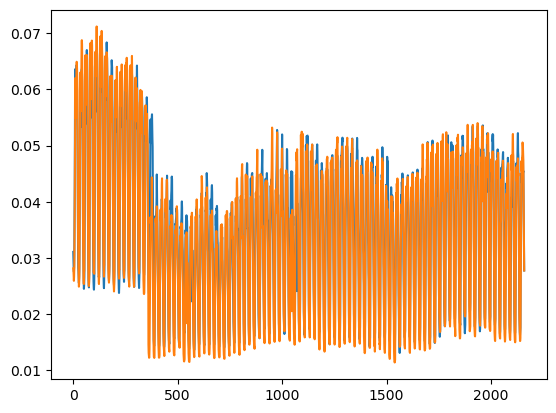

In [256]:
plt.plot(pred)
plt.plot(y_train)

---

# 비교군 모델

- 타겟데이터를 피팅하고 예측하는 모델
- 소스데이터를 학습하고 타겟데이터를 예측하는 모델

`-` non pretrained model

In [257]:
K.clear_session()
modelnon0 = Sequential() # Sequeatial Model
modelnon0.add(LSTM(64, return_sequences=True,input_shape=(24, 1)))# (timestep, feature)
modelnon0.add(LSTM(64))
modelnon0.add(Dense(1)) # output = 1
modelnon0.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)
start_timenon0 = time.time()
modelnon0.fit(x_train,y_train, epochs=100,
          batch_size=1, verbose=1, callbacks=[early_stop])
end_timenon0 = time.time()

Epoch 1/100
2160/2160 [==============================] - 14s 5ms/step - loss: 5.4045e-05
Epoch 2/100
2160/2160 [==============================] - 12s 5ms/step - loss: 2.3120e-05
Epoch 3/100
2160/2160 [==============================] - 12s 5ms/step - loss: 1.9951e-05
Epoch 4/100
2160/2160 [==============================] - 12s 5ms/step - loss: 1.8749e-05
Epoch 5/100
2160/2160 [==============================] - 12s 5ms/step - loss: 1.8339e-05
Epoch 6/100
2160/2160 [==============================] - 12s 5ms/step - loss: 1.8754e-05
Epoch 6: early stopping


---

`-` using pretrain model(no freezing)

In [241]:
K.clear_session()
model01 = Sequential() # Sequeatial Model
model01.add(LSTM(64, return_sequences=True, input_shape=(24, 1))) # (timestep, feature)
model01.add(LSTM(64, return_sequences=True)) # 연결한 모델의 차원을 맞추기 위해 시퀀스 반환을 함
model01.add(Dense(1)) # output 사용 x
model01.compile(loss='mean_squared_error', optimizer='adam')
np.random.seed(1)
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

model01.fit(lstm_x, lstm_y, epochs=100,
          batch_size=128, verbose=1, callbacks=[early_stop])

Epoch 1/100
2835/2835 [==============================] - 71s 24ms/step - loss: 8.4261e-04
Epoch 2/100
2835/2835 [==============================] - 70s 25ms/step - loss: 8.4190e-04
Epoch 3/100
2835/2835 [==============================] - 71s 25ms/step - loss: 8.4190e-04
Epoch 4/100
2835/2835 [==============================] - 72s 25ms/step - loss: 8.4205e-04
Epoch 4: early stopping


In [242]:
pretrained_layers = model01.layers[:-1]
for layer in model01.layers:
    layer.trainable = True # freezing
    

model012 = Sequential(pretrained_layers)
model012.add(LSTM(64, input_shape=(24,64)))
model012.add(Dense(1))
model012.compile(loss='mean_squared_error', optimizer='adam')

early_stop = EarlyStopping(monitor='loss', patience=5, verbose=0)
start_time22 = time.time()
model012.fit(x_train, y_train, epochs=100,
          batch_size=128, verbose=0, callbacks=[early_stop])
end_time22 = time.time()

---

# test

- 인코더 디코더 모델을 쓰기 위해서 data size를 맞춰주는 것이 매우 중요하다.

In [177]:
a = ((X_scale.shape[0] // x_test.shape[0])*x_test.shape[0])
X_ad_test= X_scale.flatten()[:int(a)].reshape(x_test.shape[0],-1)
#y_ad_test = y_scale[:int(a)].reshape(x_test.shape[0],-1)

In [204]:
X_ad_test.shape, x_test.shape, y_test.shape

((240, 1514), (240, 24), (240, 1))

---

In [258]:
pred2 = model.predict([X_ad_test,x_test])
pred3 = modelnon0.predict(x_test)
pred4 = model012.predict(x_test)

8/8 [==============================] - 0s 5ms/step


`-` y plot

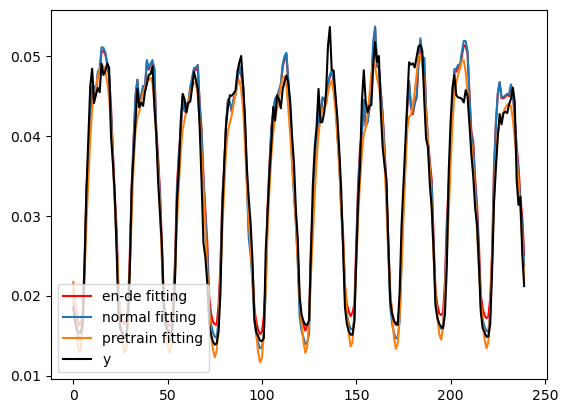

In [259]:
plt.plot(pred2, color = 'red',label = 'en-de fitting')
plt.plot(pred3,label = 'normal fitting')
plt.plot(pred4,label = 'pretrain fitting')
plt.plot(y_test,label = 'y', color = 'black')
plt.legend(loc='lower left')
plt.show()

`-` **MSE**

In [277]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
mse1= mean_squared_error(y_test, pred2)
mse2= mean_squared_error(y_test, pred3)
mse3= mean_squared_error(y_test, pred4)
mae1= mean_absolute_error(y_test, pred2)
mae2= mean_absolute_error(y_test, pred3)
mae3= mean_absolute_error(y_test, pred4)
print('en-de fitting   ',f"MSE : {mse1:.8f}",f"MAE : {mae1:.8f}")
print('normal fitting  ',f"MSE : {mse2:.8f}",f"MAE : {mae2:.8f}")
print('pretrain fitting',f"MSE : {mse3:.8f}",f"MAE : {mae3:.8f}")

en-de fitting    MSE : 0.00000691 MAE : 0.00212697
normal fitting   MSE : 0.00000632 MAE : 0.00196587
pretrain fitting MSE : 0.00000689 MAE : 0.00205653


`-` 정리/보완
- 해당 실험에서 normal fitting이 MSE 지표가 가장 좋게 나왔지만 유의한 수준이라고 보기는 어렵다
- 소스데이터의 크기가 기존 pretrain 모델은 많이 커야하지만 encoder- decoder 방법 모델은 target 데이터의 크기에 data size가 따라가기 때문에 source data의 크기가 비교적 작아도 될 것이다
- encoder-decoder 방법 모델에서 소스데이터를 처리하는 방법을 더 고민해야할 것이다. 현재는 단순히 data size에 맞추어 shape를 잘랐기 때문이다.